# Introduction

This notebook is intended to address this question:

> Does the data processing introduce a bias? The joint moment calculation makes use of marker coordinates. The joint angle calculation uses the same marker coordinates. If there was a random measurement error in a marker, it would affect both and this may result in correlations that show up in the sys id results. We should be able to test this effect and conclude whether it is a problem. Here is an idea: (1) make an average (periodic and unperturbed) gait cycle from raw data (marker coordinates and GRF) and repeat it over and over to create the same amount of data that you usually work with. (2) add small random numbers to all samples, (3) compute angles and torques in the same way you normally do, (4) do the sys id and see what comes out. If this result is the same as what you get from the perturbation experiment, that would be bad news...

# Imports

In [1]:
import sys
sys.path.append('../src')

In [2]:
import operator

In [3]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from gaitanalysis.motek import markers_for_2D_inverse_dynamics
from gaitanalysis.gait import GaitData
from gaitanalysis.controlid import SimpleControlSolver

In [4]:
import utils
from gait_landmark_settings import settings

In [5]:
%matplotlib inline

In [6]:
from IPython.core.pylabtools import figsize

# Load and Process Data

Load the path to the directory with the experimental data.

In [7]:
trials_dir = utils.config_paths()['raw_data_dir']

Pick a trial.

In [8]:
trial_number = '018'

In [9]:
trial = utils.Trial(trial_number)

In [10]:
trial.prep_data('First Normal Walking')

Loading pre-cleaned data: /home/moorepants/Manuscripts/gait-control-direct-id-paper/processed-data/cleaned-data/018-first-normal-walking.h5
_write_event_data_frame_to_disk took 0.02 s to execute.
Loading pre-computed inverse dynamics from /home/moorepants/Manuscripts/gait-control-direct-id-paper/processed-data/gait-data/018-first-normal-walking.h5.
_write_inverse_dynamics_to_disk took 0.05 s to execute.
Loading pre-computed gait cycles from /home/moorepants/Manuscripts/gait-control-direct-id-paper/processed-data/gait-data/018-first-normal-walking.h5.
_section_into_gait_cycles took 0.06 s to execute.


First, extract the data from the first normal walking period in the trial.

In [11]:
gait_data = GaitData(trial.event_data_frames['First Normal Walking'])
gait_data.grf_landmarks('FP2.ForY', 'FP1.ForY',
                        filter_frequency=trial.grf_filter_frequency,
                        threshold=trial.grf_threshold)
cycles = gait_data.split_at('right', num_samples=trial.num_samples_lower_bound)

In [12]:
cycles.shape

(62, 75, 192)

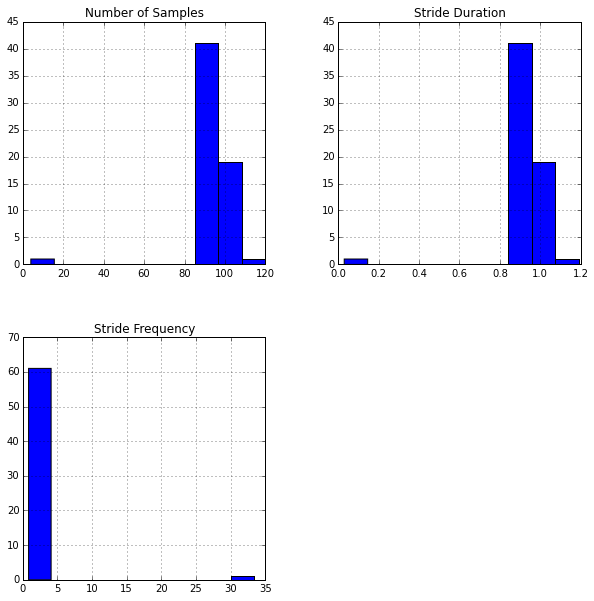

In [13]:
figsize(10, 10)
axes = gait_data.gait_cycle_stats.hist()

# Generate Fake Data

Now extract one good step from the bunch. The 21st step looks as good as any:

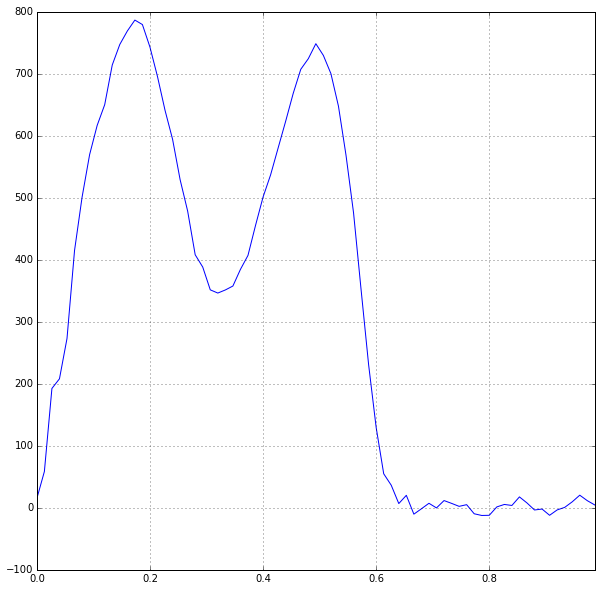

In [14]:
cycles.iloc[20]['FP2.ForY'].plot()

This gives a list of measurements needed for the 2D inverse dynamics caluclations and also a list of just the marker labels.

In [15]:
measurements = markers_for_2D_inverse_dynamics('full')
measurement_list = reduce(operator.add, measurements)
marker_list = reduce(operator.add, measurements[:2])

Copy the cycle so it no longer points to the original data arrays.

In [16]:
cycle = cycles.iloc[20][measurement_list + ['Original Time']].copy()

This code fits an nth order Fourier series to each signal needed for the 2D dynamics and then builds a smoothed step data frame.

In [17]:
smoothed_cycle = cycle.copy()

time = cycle['Original Time'].values

freq = 1.0 / (time[-1] - time[0]) # cycle / sec
print('Cycle frequency = {:0.2f} hz'.format(freq))
omega = 2.0 * np.pi * freq # rad /sec
print('Cycle frequency = {:0.2f} rad/s'.format(omega))

fourier_order = 20
initial_coeff = np.ones(1 + 2 * fourier_order)

for measurement in measurement_list:
    signal = cycle[measurement].values
    popt, pcov = utils.fit_fourier(time, signal, initial_coeff, omega)
    eval_fourier = utils.fourier_series(omega)
    smoothed_cycle[measurement] = eval_fourier(time, *popt)

Cycle frequency = 1.06 hz
Cycle frequency = 6.63 rad/s


This plot shows the Fourier series (green line) vs the original data (blue dots).

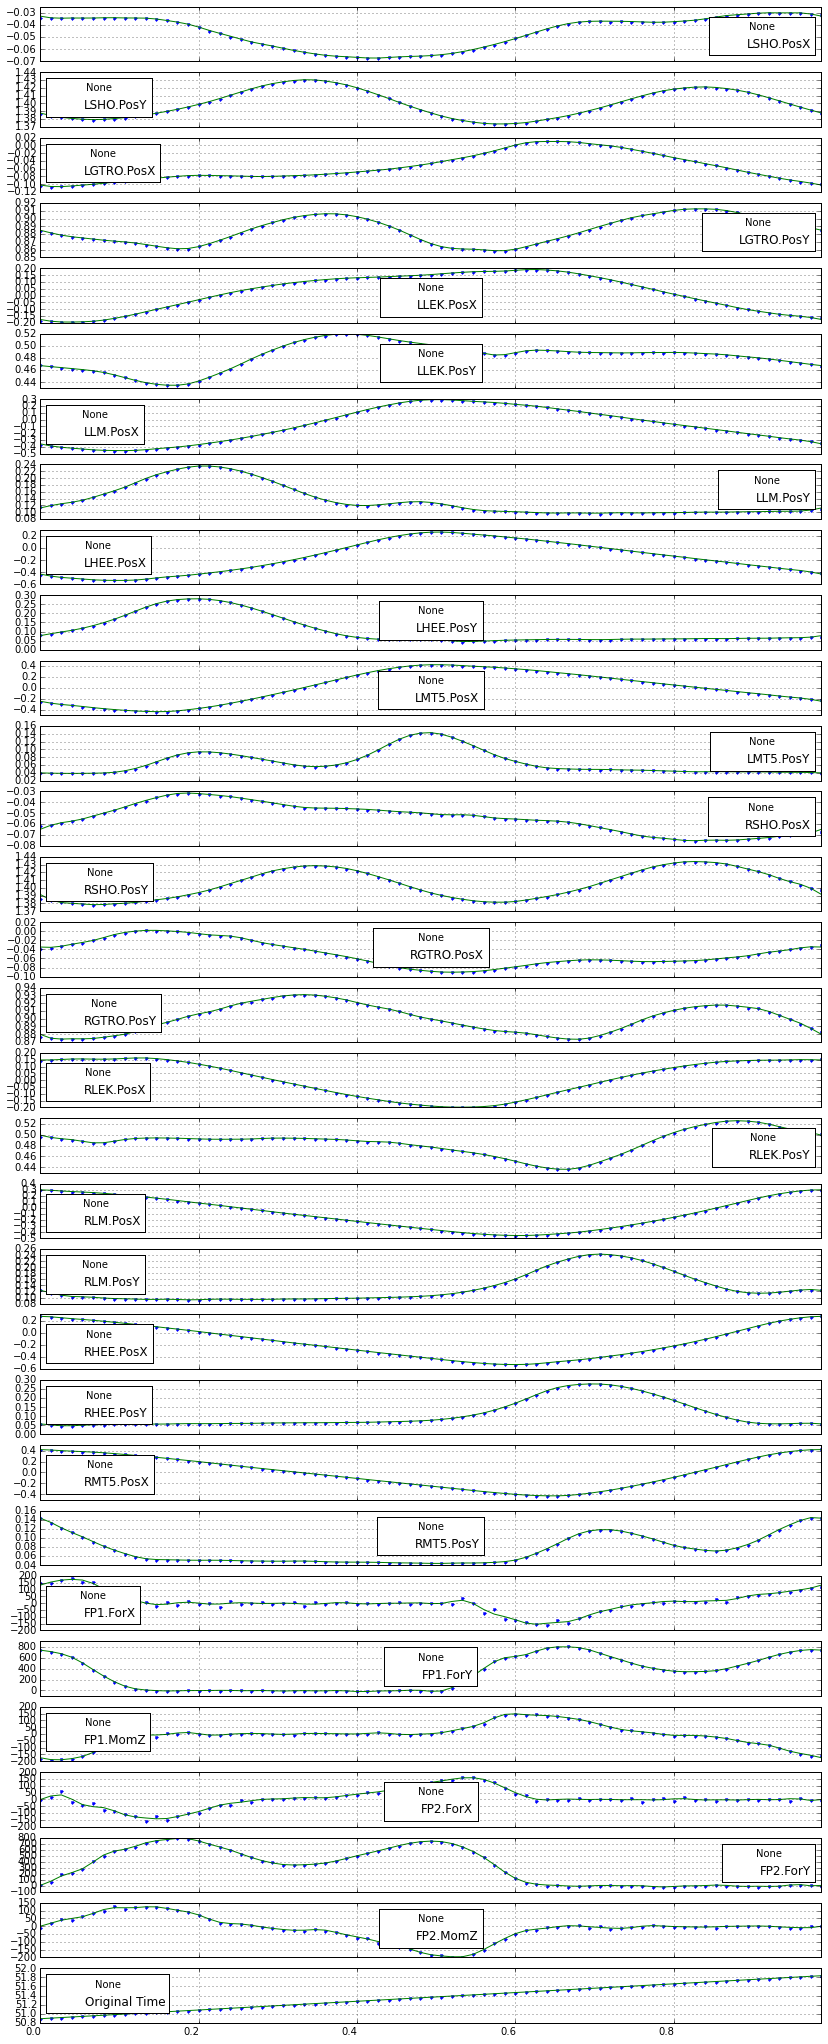

In [18]:
figsize(14, 40)
axes = cycle.plot(style='.', subplots=True)
for i, ax in enumerate(axes):
    smoothed_cycle.iloc[:, i].plot(ax=ax)

Now build some fake data by repeating the smoothed steps..

In [19]:
fakedata = {}
for i in range(500):
    fakedata[i] = smoothed_cycle.copy()
fake_data_df = pandas.concat(fakedata, ignore_index=True)
fake_data_df.index = np.linspace(0.0, len(fake_data_df) * 0.01 - 0.01, len(fake_data_df))

Now add random Gaussian noise with a mean of zero and standard deviation of 5 mm to all of the marker measurements.

In [20]:
shape = fake_data_df[marker_list].shape
fake_data_df[marker_list] += np.random.normal(scale=0.005, size=shape)

This is a plot of the first ~11 gait cycles of the fake data (includes the noise on the markers).

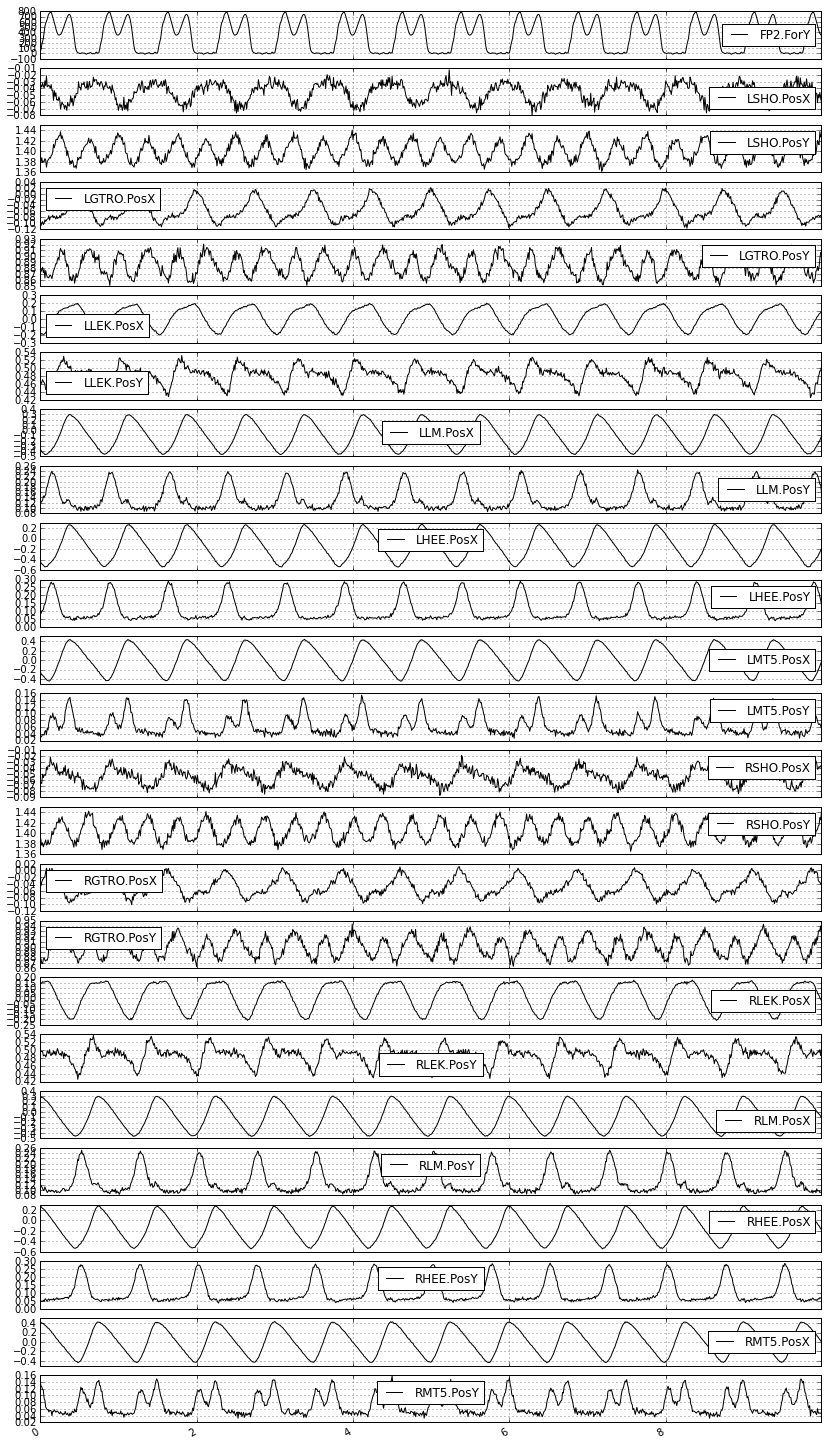

In [21]:
figsize(14, 28)
axes = fake_data_df[['FP2.ForY'] + marker_list].iloc[:1000].plot(subplots=True)

Now compute the inverse dynamics on the noisy data.

In [22]:
gait_data = GaitData(fake_data_df)
subject_mass = float(trial.meta_data['subject']['mass'])
args = list(measurements) + [subject_mass, 6.0]
df = gait_data.inverse_dynamics_2d(*args)

This shows an example of the joint angles, rates, and torques.

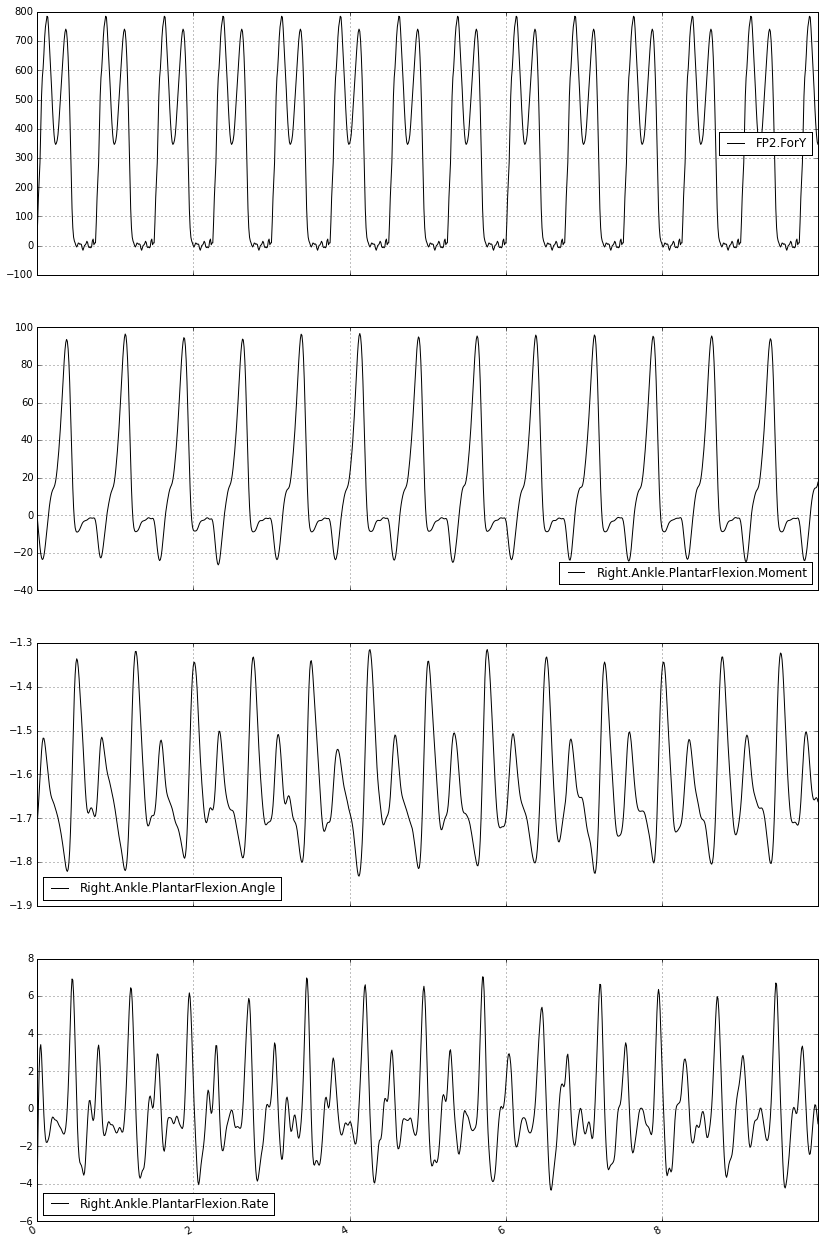

In [23]:
figsize(14, 24)
subset = ['FP2.ForY',
          'Right.Ankle.PlantarFlexion.Moment',
          'Right.Ankle.PlantarFlexion.Angle',
          'Right.Ankle.PlantarFlexion.Rate']
axes = gait_data.data[subset].iloc[:1000].plot(subplots=True)

# Identify the Controller

Now, to identify the controller the steps need to be found.

In [24]:
null = gait_data.grf_landmarks('FP2.ForY', 'FP1.ForY', threshold=30.0)

In [25]:
fake_steps = gait_data.split_at('right', num_samples=20)

The only variation in the steps is due to the marker coordinates noise.

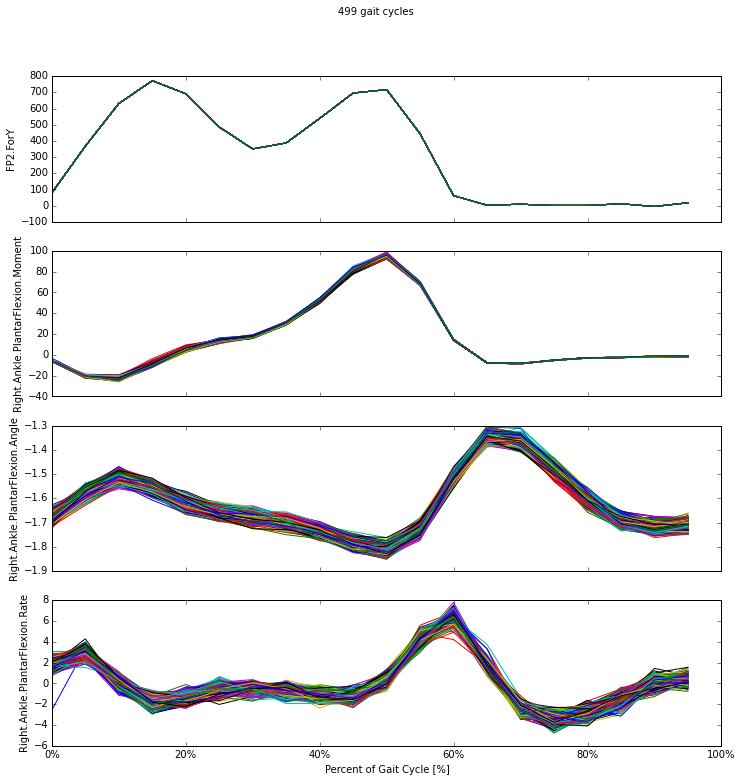

In [26]:
figsize(12, 12)
axes = gait_data.plot_gait_cycles(*subset)

Now identify a joint centric gain scheduled controller as usual.

In [27]:
solver = SimpleControlSolver(fake_steps, trial.sensors, trial.controls)

In [28]:
gain_inclusion_matrix = np.zeros((len(trial.controls), len(trial.sensors))).astype(bool)
for i, row in enumerate(gain_inclusion_matrix):
    row[2 * i:2 * i + 2] = True

In [29]:
result = solver.solve(gain_inclusion_matrix=gain_inclusion_matrix)

Generating gain plot.
0.33 s


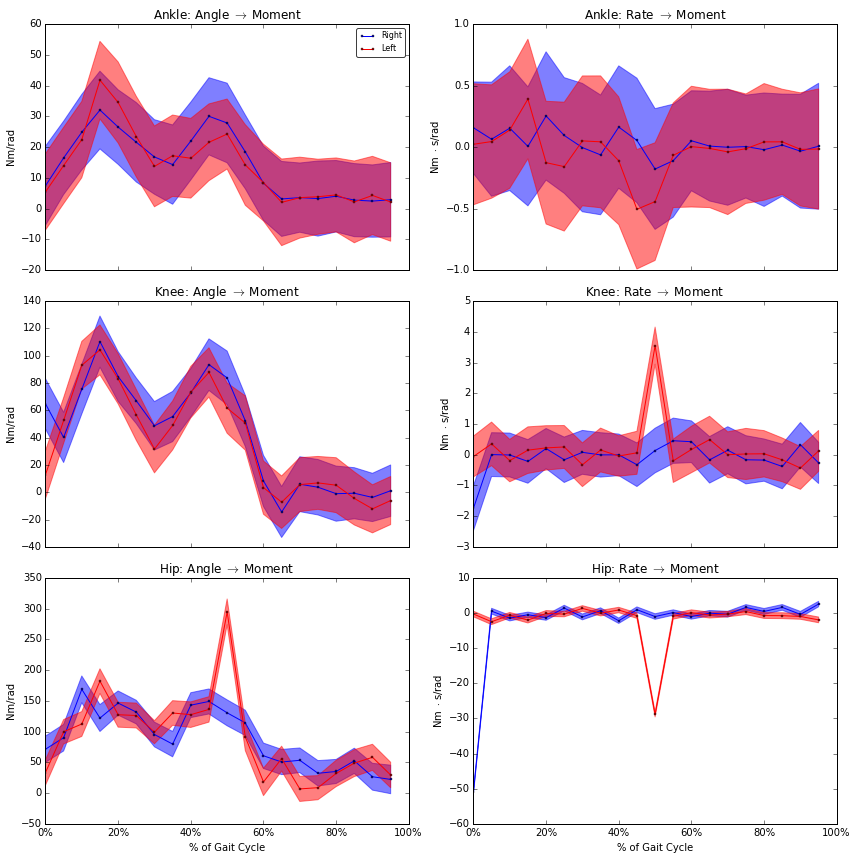

In [30]:
fig, axes = utils.plot_joint_isolated_gains(trial.sensors, trial.controls, result[0], result[3])

Interesting that we see a curve similar in shape, but not magnitude, in the angle to moment gain curves. Below I calculate the ratio of the right vertical ground reaction force to the gain curve and then plot the gain curves, normalized to by this ratio with respect to the vertical ground reaction force.

GRF to Ankle Gain ratio = 14.763
GRF to Knee Gain ratio = 4.801
GRF to Hip Gain ratio = 2.602


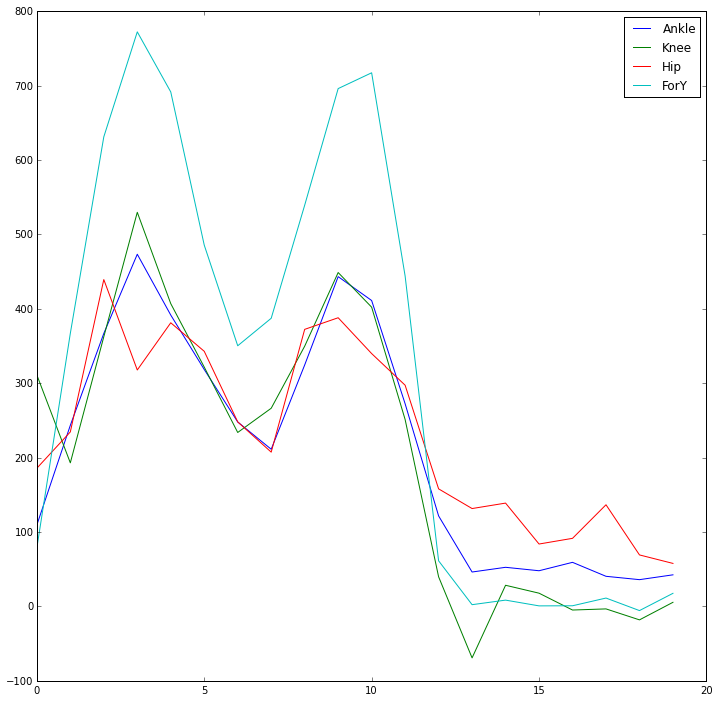

In [31]:
for m, a, seg in zip([0, 1, 2], [0, 2, 4], ['Ankle', 'Knee', 'Hip']):
    ratios = fake_steps.iloc[0]['FP2.ForY'] / result[0][:, m, a]
    ratio = ratios[:11].mean()
    print('GRF to {} Gain ratio = {:0.3f}'.format(seg, ratio))
    plt.plot(ratio * result[0][:, m, a], label=seg)
    
plt.plot(fake_steps.iloc[0]['FP2.ForY'], label='ForY')
plt.legend()

# Footer

In [32]:
!git rev-parse HEAD

6af0c229bb0a9edf78f8489d5f0efe02d5685a57


In [33]:
!git --git-dir=/home/moorepants/src/GaitAnalysisToolKit/.git --work-tree=/home/moorepants/src/GaitAnalysisToolKit rev-parse HEAD

9e80dfdcfe0a14b44e0ebcbadb6e9e827d215c3c


In [34]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py

Installed version_information.py. To use it, type:
  %load_ext version_information


In [35]:
%load_ext version_information

In [36]:
%version_information numpy, scipy, pandas, matplotlib, tables, oct2py, dtk, gaitanalysis

Software,Version
Python,2.7.9 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython,3.0.0
OS,Linux 3.13.0 49 generic x86_64 with debian jessie sid
numpy,1.9.2
scipy,0.15.1
pandas,0.16.0
matplotlib,1.4.2
tables,3.1.1
oct2py,3.1.0
dtk,0.4.0


In [37]:
!conda list

# packages in environment at /home/moorepants/anaconda/envs/gait-direct-id-paper:
#
backports.ssl-match-hostname 3.4.0.2                   <pip>
cairo                     1.12.18                       0  
dateutil                  2.4.1                    py27_0  
dynamicisttoolkit         0.4.0                    py27_0  
fastcache                 1.0.2                    py27_0  
fontconfig                2.11.1                        2  
freetype                  2.4.10                        0  
gaitanalysistoolkit (/home/moorepants/src/GaitAnalysisToolKit) 0.2.0.dev0                <pip>
hdf5                      1.8.14                        0  
ipython                   3.0.0                    py27_0  
ipython-notebook          3.0.0                    py27_1  
jinja2                    2.7.3                    py27_1  
jsonschema                2.4.0                    py27_0  
libpng                    1.5.13                        1  
libsodium                 0.4.5         

In [38]:
!pip freeze

backports.ssl-match-hostname==3.4.0.2
DynamicistToolKit==0.4.0
fastcache==1.0.2
-e git+git@github.com:csu-hmc/GaitAnalysisToolKit.git@9e80dfdcfe0a14b44e0ebcbadb6e9e827d215c3c#egg=GaitAnalysisToolKit-origin_speedup-inverse-dynamics
ipython==3.0.0
Jinja2==2.7.3
jsonschema==2.4.0
MarkupSafe==0.23
matplotlib==1.4.2
mistune==0.5.1
nose==1.3.4
numexpr==2.3.1
numpy==1.9.2
oct2py==3.1.0
pandas==0.16.0
ptyprocess==0.4
Pygments==2.0.2
pyparsing==2.0.1
PySide==1.2.1
python-dateutil==2.4.2
pytz==2015.2
PyYAML==3.11
pyzmq==14.5.0
scipy==0.15.1
seaborn==0.5.1
six==1.9.0
snakeviz==0.3.1
sympy==0.7.6
tables==3.1.1
terminado==0.5
tornado==4.1
